In [20]:
from captum.attr import IntegratedGradients,Occlusion, GradientShap, Saliency
import captum
import torch
import torchaudio
from pathlib import Path
import os
import pandas as pd
import numpy as np
from data_utils import emotion_to_ordinal_dict, ordinal_to_emotion_dict
import matplotlib.pyplot as plt
import librosa
import librosa.display

# Model interpretation

In [2]:
from MMFUSION import model, data

ipynb_path = os.path.dirname(os.path.realpath("__file__"))
cur_path = Path(ipynb_path)
train_info_path = (cur_path / "datasets/challengeA_data/2022challengeA_train.csv").resolve()
train_folder_path = (cur_path / "datasets/challengeA_data/train").resolve()

load_train_state_path = (cur_path / "saved_models" / "MMFUSION_train" / "MMFUSION.tar")
train_ds = pd.read_csv(train_info_path, index_col=0)


In [3]:
device = "cuda"

model_collation, history = data.load_inference_model(load_train_state_path)
model = model_collation["model"].to(device)
torch.backends.cudnn.enabled=False
model.eval()
inf_pipeline = model_collation["inference_pipeline"]




In [46]:
# Group by emotions and take n of each:
emotions = train_ds["emotion"].unique()
samples_per_emotion = 10

samples_dict = {}
for g_name, g in train_ds.groupby(by="emotion"):
    sampled = np.random.choice(len(g), size=samples_per_emotion)
    s_list = []
    for s in sampled:
        d = g.iloc[[s]].to_dict()
        s_list += [{k: d[k][list(d[k].keys())[0]] for k in d.keys()}]
    samples_dict[g_name] = s_list

print(samples_dict["angry"])

[{'file_id': 'c5d62ce2-ae35-42da-b2a2-9ca3f2540e9e.wav', 'emotion': 'angry', 'origin': 'crema'}, {'file_id': '61fe7840-91e3-457b-befa-4143ee6e7925.wav', 'emotion': 'angry', 'origin': 'crema'}, {'file_id': '464eb07c-c073-4003-9288-665dc87b0866.wav', 'emotion': 'angry', 'origin': 'tess'}, {'file_id': '4c8a9c25-f369-4745-91cd-fa01242318ab.wav', 'emotion': 'angry', 'origin': 'crema'}, {'file_id': 'b9a7d838-c8f8-44bf-bdd0-9c9f3c102464.wav', 'emotion': 'angry', 'origin': 'crema'}, {'file_id': 'cf3aa545-a446-4dcb-a8d1-da1952e1130f.wav', 'emotion': 'angry', 'origin': 'crema'}, {'file_id': 'e7280b32-a25f-49bc-b21c-664d0d810a4e.wav', 'emotion': 'angry', 'origin': 'ravdess'}, {'file_id': '51005eb5-04e9-4c8e-94a3-1b10db9eed18.wav', 'emotion': 'angry', 'origin': 'crema'}, {'file_id': '2fc102c3-5510-41d5-b1db-e153ea9fe3a8.wav', 'emotion': 'angry', 'origin': 'ravdess'}, {'file_id': '8523a178-d49b-430a-ade7-cf9ecc601695.wav', 'emotion': 'angry', 'origin': 'crema'}]


torch.Size([1, 144, 598])
torch.Size([1, 144, 1])
torch.Size([2, 144, 598])
torch.Size([2, 144, 1])
torch.Size([5, 144, 598])
torch.Size([5, 144, 1])


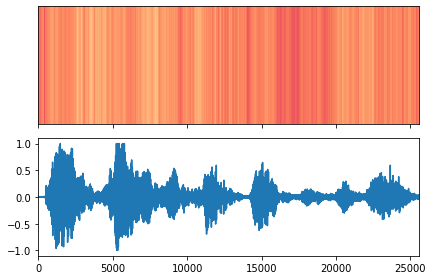

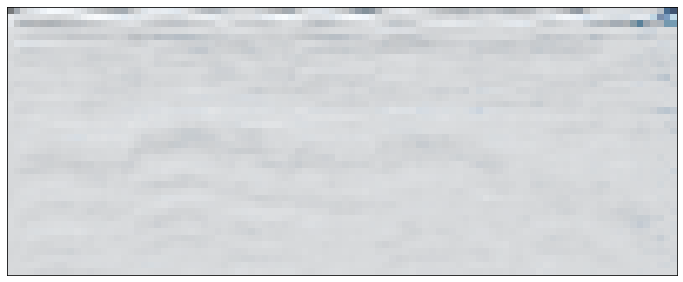

/opt/conda/lib/python3.8/site-packages/captum/attr/_utils/visualization.py:44: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


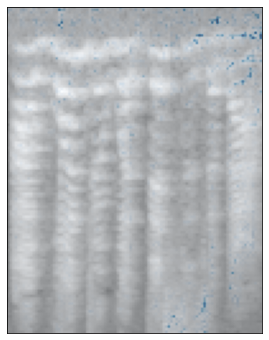

torch.Size([1, 144, 598])
torch.Size([1, 144, 1])
torch.Size([2, 144, 598])
torch.Size([2, 144, 1])
torch.Size([5, 144, 598])
torch.Size([5, 144, 1])


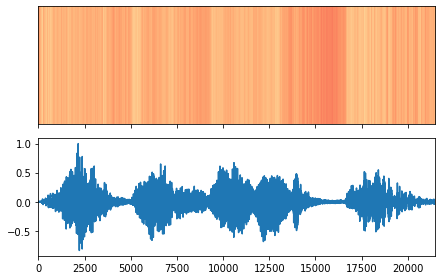

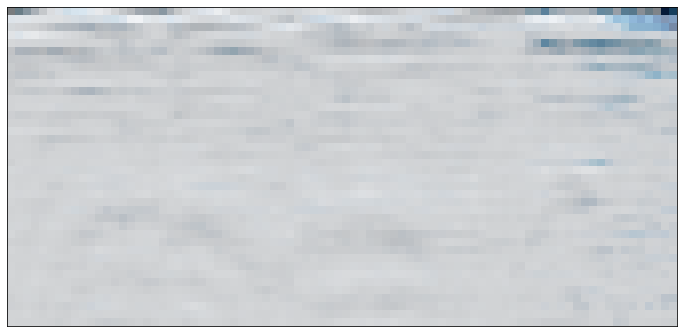

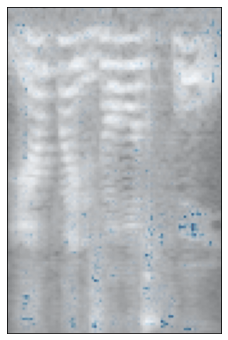

torch.Size([1, 144, 598])
torch.Size([1, 144, 1])
torch.Size([2, 144, 598])
torch.Size([2, 144, 1])
torch.Size([5, 144, 598])
torch.Size([5, 144, 1])


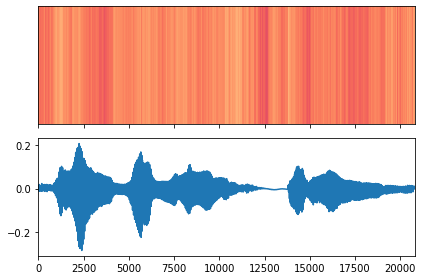

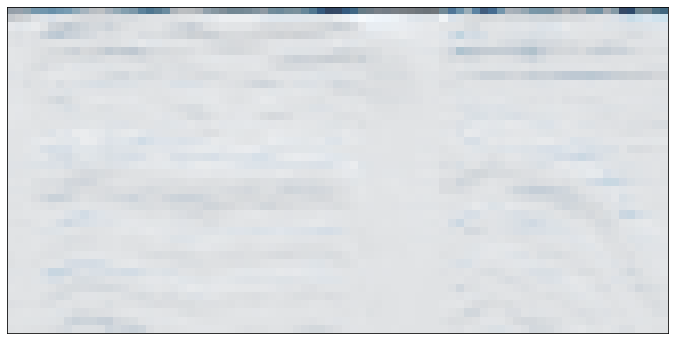

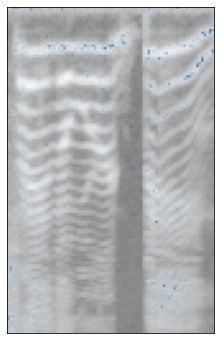

torch.Size([1, 144, 598])
torch.Size([1, 144, 1])
torch.Size([2, 144, 598])
torch.Size([2, 144, 1])
torch.Size([5, 144, 598])
torch.Size([5, 144, 1])


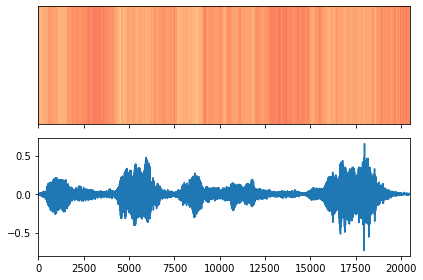

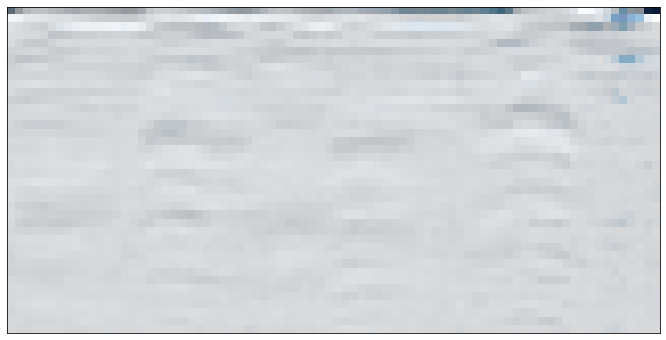

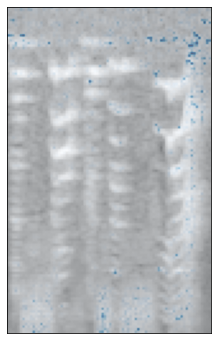

torch.Size([1, 144, 598])
torch.Size([1, 144, 1])
torch.Size([2, 144, 598])
torch.Size([2, 144, 1])
torch.Size([5, 144, 598])
torch.Size([5, 144, 1])


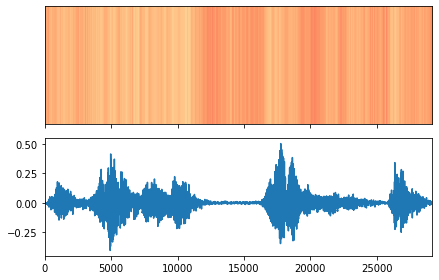

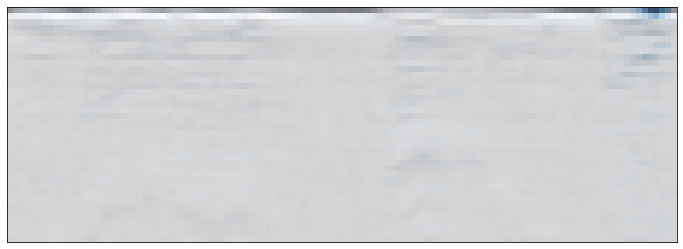

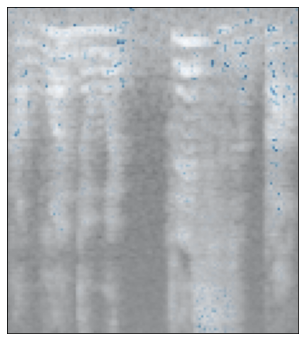

torch.Size([1, 144, 598])
torch.Size([1, 144, 1])
torch.Size([2, 144, 598])
torch.Size([2, 144, 1])
torch.Size([5, 144, 598])
torch.Size([5, 144, 1])


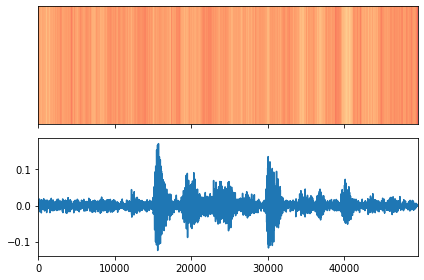

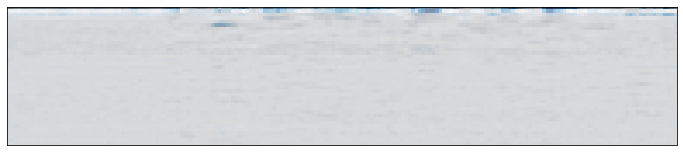

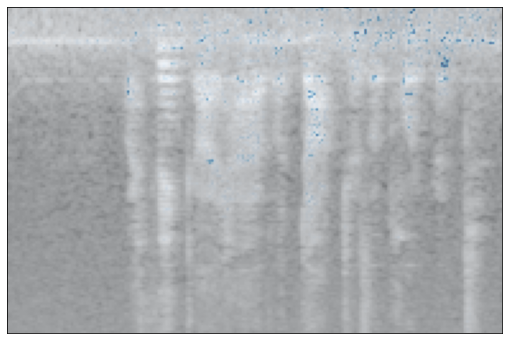

torch.Size([1, 144, 598])
torch.Size([1, 144, 1])
torch.Size([2, 144, 598])
torch.Size([2, 144, 1])
torch.Size([5, 144, 598])
torch.Size([5, 144, 1])


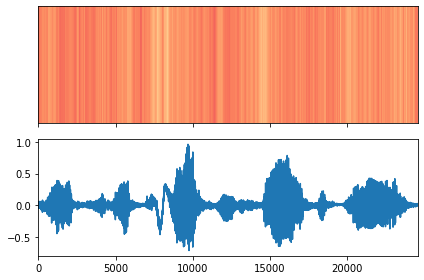

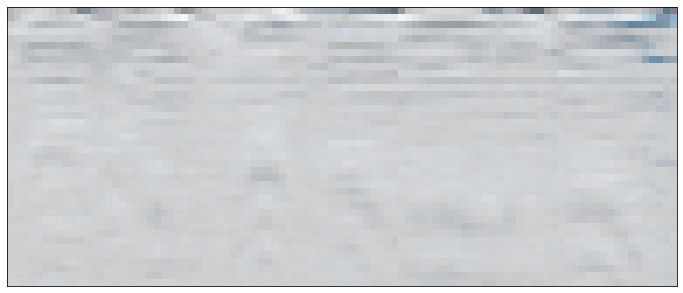

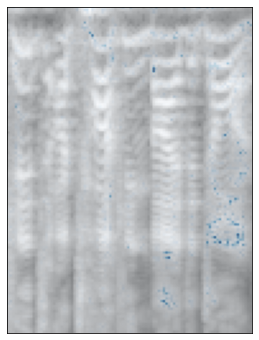

torch.Size([1, 144, 598])
torch.Size([1, 144, 1])
torch.Size([2, 144, 598])
torch.Size([2, 144, 1])
torch.Size([5, 144, 598])
torch.Size([5, 144, 1])


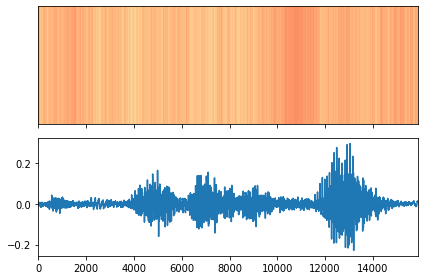

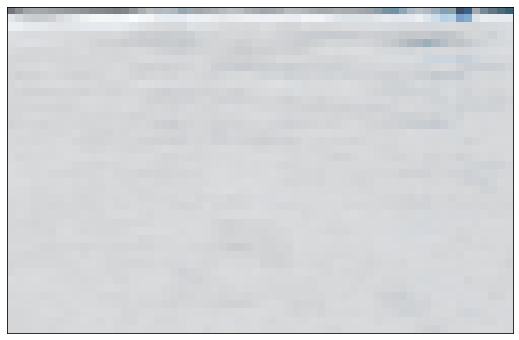

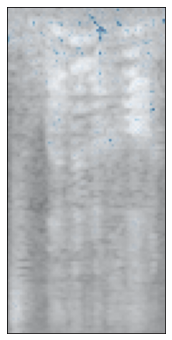

torch.Size([1, 144, 598])
torch.Size([1, 144, 1])
torch.Size([2, 144, 598])
torch.Size([2, 144, 1])
torch.Size([5, 144, 598])
torch.Size([5, 144, 1])


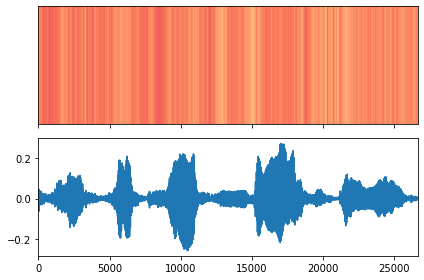

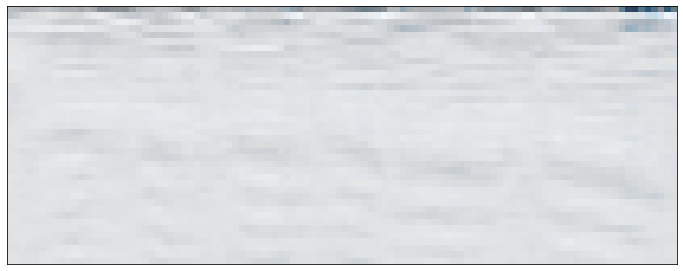

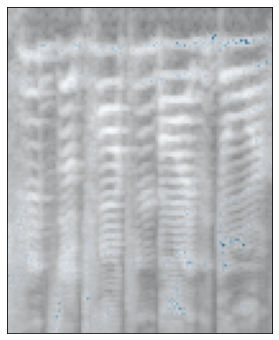

torch.Size([1, 144, 598])
torch.Size([1, 144, 1])
torch.Size([2, 144, 598])
torch.Size([2, 144, 1])
torch.Size([5, 144, 598])
torch.Size([5, 144, 1])


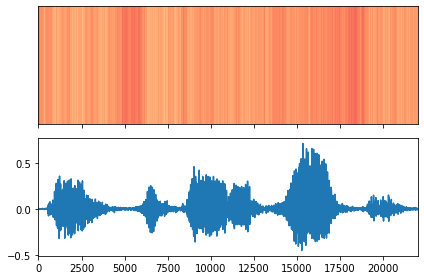

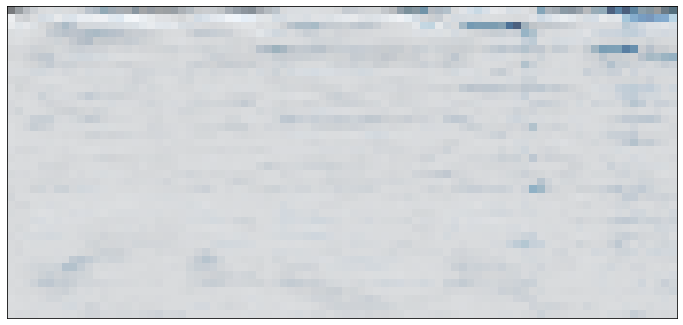

/opt/conda/lib/python3.8/site-packages/captum/attr/_utils/visualization.py:44: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


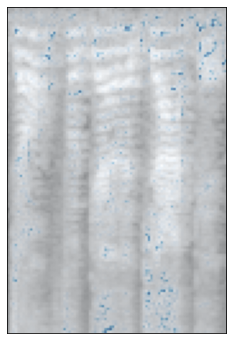

In [72]:
for em in samples_dict.keys():
    # Load file
    for sample in samples_dict[em]:
        # Load and resample
        file_path = (train_folder_path / sample["file_id"])
        waveform, sr = torchaudio.load(file_path)
        waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)
        waveform = torch.unsqueeze(torch.as_tensor(data.sample_preprocessing(waveform)), 0)
        
        # Prepare data and label
        in_waveform, in_mfcc, in_spectro = inf_pipeline(waveform)
        
        #in_waveform = torch.rand(1,1,100)
        in_waveform.requires_grad = True
        in_waveform = in_waveform.to(device)
        
        #in_mfcc = torch.rand(1,1,40,313)
        in_mfcc.requires_grad = True
        in_mfcc = in_mfcc.to(device)
        
        #in_spectro = torch.rand(1,3,128, 50)
        in_spectro.requires_grad = True
        in_spectro = in_spectro.to(device)
        

        input_data = (in_waveform, in_mfcc, in_spectro)

        y = emotion_to_ordinal_dict[em]

        # Use captum
        ig = IntegratedGradients(model)
        gs = GradientShap(model)
        sal = Saliency(model)
        occlusion = Occlusion(model)
        """
        model.zero_grad()
        attributions_occ = occlusion.attribute(input_data,
                                            strides = ((1,3),(1,3,3),(1,3, 3)),
                                            sliding_window_shapes=((1,6),(1,6,6),(1,6,6)),
                                            baselines=input_data*0)
        attributions_occ = attributions_occ[y,:,:,:]
        """
        model.zero_grad()
        attributions_sal = sal.attribute(input_data, target=y)
        
        model.zero_grad()
        attributions_ig = ig.attribute(input_data, target=y, baselines = (in_waveform * 0, in_mfcc*0, in_spectro*0),return_convergence_delta=False, n_steps=2)
        
        model.zero_grad()
        attributions_shap = gs.attribute(input_data, target=y, baselines = (in_waveform * 0, in_mfcc*0, in_spectro*0),return_convergence_delta=False)


        # Adapt the various modalities for visualization
        # Waveform
        in_waveform = torch.squeeze(in_waveform).detach().cpu().numpy()
        out_waveform_ig = torch.squeeze(attributions_ig[0]).detach().cpu().numpy()
        
        in_waveform = np.trim_zeros(in_waveform)
        trimmed_len = len(in_waveform)
        
        out_waveform_ig = out_waveform_ig[:trimmed_len]
        out_waveform_ig = np.log(np.abs(out_waveform_ig)+1e-12)
        
        # Spectrogram
        spectro_trimmed_len = int((313*trimmed_len)/80000)
        
        out_spectro_ig = torch.permute(torch.squeeze(attributions_ig[2]),(1,2,0)).detach().cpu().numpy()
        out_spectro_ig = out_spectro_ig[:,:spectro_trimmed_len,:]
        
        in_spectro = torch.permute(torch.squeeze(input_data[2]),(1,2,0)).detach().cpu().numpy()
        in_spectro = np.log(in_spectro+1e-9)
        in_spectro = in_spectro[:,:spectro_trimmed_len,:]

        # MFCC
        in_mfcc = torch.unsqueeze(torch.squeeze(in_mfcc),-1).repeat(1,1,3).detach().cpu().numpy()
        in_mfcc = in_mfcc[:,:spectro_trimmed_len,:]

        out_mfcc_ig = torch.unsqueeze(torch.squeeze(attributions_ig[1]),-1).repeat(1,1,3).detach().cpu().numpy()
        out_mfcc_ig = out_mfcc_ig[:,:spectro_trimmed_len,:]
        
        # Plot Waveform
        x = range(len(in_waveform))
        fig, (ax,ax2) = plt.subplots(nrows=2, sharex=True)
        extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
        
        ax.imshow(out_waveform_ig[np.newaxis,:], cmap="magma", aspect="auto", extent=extent)
        ax.set_yticks([])
        ax.set_xlim(extent[0], extent[1])

        ax2.plot(x,in_waveform)

        plt.tight_layout()
        plt.show()

        #_ = captum.attr.visualization.visualize_image_attr(out_spectro_sal, in_spectro, method="blended_heat_map", fig_size=(12,6))
        _ = captum.attr.visualization.visualize_image_attr(out_mfcc_ig, in_mfcc, method="blended_heat_map", fig_size=(12,6))
        _ = captum.attr.visualization.visualize_image_attr(out_spectro_ig, in_spectro, method="blended_heat_map", fig_size=(12,6))
        #_ = captum.attr.visualization.visualize_image_attr(out_spectro_shap, in_spectro, method="blended_heat_map", fig_size=(12,6))
        


In [84]:
def compute_weighted_window(orig_signal, signal_weights, window_size):
    weighted_signal = np.multiply(orig_signal,signal_weights)

    missing_frames = window_size - (len(orig_signal)%window_size)
    print(missing_frames)
    weighted_signal = np.concatenate((weighted_signal,weighted_signal[:missing_frames]), axis=0)
    print(len(weighted_signal))
    n_splits = len(weighted_signal)/window_size
    
    splits = np.array(np.split(weighted_signal, n_splits))
    print(splits)
    return splits.sum(axis=0)




1
12
[[ 0.1  0.4  0.9]
 [ 1.6  2.5  3.6]
 [ 4.9  6.4  8.1]
 [10.  12.1  0.1]]


array([16.6, 21.4, 12.7])